In [11]:
!pip install pmdarima
!pip install optuna
!pip install pandas-ta
!pip install catbost
!pip install prophet
!pip install finance-datareader
!pip install neuralprophet

ERROR: Could not find a version that satisfies the requirement catbost (from versions: none)
ERROR: No matching distribution found for catbost
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 642.9/642.9 kB 24.5 MB/s eta 0:00:00
  Attempting uninstall: holidays
    Found existing installation: holidays 0.21.13
    Uninstalling holidays-0.21.13:
      Successfully uninstalled holidays-0.21.13
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
neuralprophet 0.6.2 requires holidays<0.22,>=0.21, but you have holidays 0.28 which is incompatible.


  Using cached holidays-0.21.13-py3-none-any.whl (378 kB)
  Attempting uninstall: holidays
    Found existing installation: holidays 0.28
    Uninstalling holidays-0.28:
      Successfully uninstalled holidays-0.28
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
prophet 1.1.4 requires holidays>=0.25, but you have holidays 0.21.13 which is incompatible.


In [26]:
import pandas as pd
import numpy as np
import random
import os
from tqdm.auto import tqdm
from xgboost import XGBRegressor
import optuna
import pandas_ta as ta
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from sklearn.model_selection import TimeSeriesSplit
from pmdarima.arima import auto_arima
import FinanceDataReader as fdr
from neuralprophet import NeuralProphet
from sklearn.neural_network import MLPRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
import random
import itertools
import matplotlib.pyplot as plt




import warnings
warnings.filterwarnings("ignore")

In [2]:
def seed_everything(seed):
  random.seed(seed)
  os.environ["PYTHONHASHSEED"] = str(seed)
  np.random.seed(seed)

seed_everything(6789)

In [3]:
train = pd.read_csv("/content/drive/MyDrive/dacon_trading_bot/train.csv")

In [9]:
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
  def __init__(self, encoder_input, decoder_input, target_input, encoder_marks, decoder_marks):
    self.encoder_input = encoder_input
    self.decoder_input = decoder_input
    self.target_input = target_input
    self.encoder_marks = encoder_marks
    self.decoder_marks = decoder_marks
  def __len__(self):
    return len(self.encoder_input)
  def __getitem__(self, i):
    return {
        "encoder_input": torch.tensor(self.encoder_input[i], dtype=torch.float32),
        "decoder_input": torch.tensor(self.decoder_input[i], dtype=torch.float32),
        "target": torch.tensor(self.target_input[i], dtype=torch.float32),
        "encoder_marks": torch.tensor(self.encoder_marks[i], dtype=torch.float32),
        "decoder_marks": torch.tensor(self.decoder_marks[i], dtype=torch.float32)
    }

class CustomDatasetTest(Dataset):
  def __init__(self, encoder_input, decoder_input, encoder_marks, decoder_marks):
    self.encoder_input = encoder_input
    self.decoder_input = decoder_input
    self.encoder_marks = encoder_marks
    self.decoder_marks = decoder_marks
  def __len__(self):
    return len(self.encoder_input)
  def __getitem__(self, i):
    return {
        "encoder_input": torch.tensor(self.encoder_input[i], dtype=torch.float32),
        "decoder_input": torch.tensor(self.decoder_input[i], dtype=torch.float32),
        "encoder_marks": torch.tensor(self.encoder_marks[i], dtype=torch.float32),
        "decoder_marks": torch.tensor(self.decoder_marks[i], dtype=torch.float32)
    }

In [7]:
# !git clone https://github.com/zhouhaoyi/Informer2020.git

Cloning into 'Informer2020'...
remote: Enumerating objects: 576, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 576 (delta 0), reused 2 (delta 0), pack-reused 573
Receiving objects: 100% (576/576), 6.49 MiB | 19.14 MiB/s, done.
Resolving deltas: 100% (328/328), done.


In [5]:
import sys
if not "Informer2020" in sys.path:
  sys.path += ["Informer2020"]

In [28]:
from Informer2020.models.model import Informer, InformerStack
import torch
import torch.nn as nn

device = torch.device("cuda")

results_df = pd.DataFrame(columns=["종목코드", "final_return"])
unique_codes = train["종목코드"].unique()

window_size, target_size = 30, 15

for idx, code in tqdm(enumerate(unique_codes), total=len(unique_codes)):
  chart_df = train[train["종목코드"]==code][["일자", "거래량", "시가", "고가", "저가", "종가"]]
  chart_df["일자"] = pd.to_datetime(chart_df["일자"], format="%Y%m%d")
  cur_enc_inputs, cur_dec_inputs = [], []
  cur_targets = []
  cur_enc_marks, cur_dec_marks = [], []
  for i in range(chart_df.shape[0] - window_size - target_size):
    date_info = chart_df.iloc[i:i+window_size+target_size, 0]
    x_dates = []
    for j in range(len(date_info)):
      x_dates.append([date_info.iloc[j].month, date_info.iloc[j].day])
    # enforce all sequence to start with 1
    open_0 = chart_df.iloc[i, 2]
    high_0 = chart_df.iloc[i, 3]
    low_0 = chart_df.iloc[i, 4]
    close_0 = chart_df.iloc[i, 5]
    volume_0 = chart_df.iloc[i, 1]
    X = chart_df.iloc[i:i+window_size, 1:].values
    Y = chart_df.iloc[i+window_size:i+window_size+target_size, 5].values
    X = np.array(X, dtype=np.float64)
    Y = np.array(Y, dtype=np.float64)
    X[:, 2-1] /= open_0
    X[:, 3-1] /= high_0
    X[:, 4-1] /= low_0
    X[:, 5-1] /= close_0
    X[:, 1-1] /= volume_0
    Y /= close_0

    start_tokens = X[:, 4].reshape((-1, 1))
    y_0 = np.zeros((target_size, 1))
    cur_dec_inputs.append(np.concatenate([start_tokens, y_0]))
    cur_targets.append(Y.reshape((-1, 1)))

    cur_enc_inputs.append(X)

    cur_enc_marks.append(x_dates[0:window_size])
    cur_dec_marks.append(x_dates[0:window_size+target_size])

  cur_enc_marks = np.array(cur_enc_marks)
  cur_dec_marks = np.array(cur_dec_marks)
  cur_enc_inputs = np.array(cur_enc_inputs)
  cur_dec_inputs = np.array(cur_dec_inputs)
  cur_targets = np.array(cur_targets)

  cur_enc_inputs = torch.tensor(cur_enc_inputs).float()
  cur_dec_inputs = torch.tensor(cur_dec_inputs).float()
  cur_targets = torch.tensor(cur_targets).float()
  cur_enc_marks = torch.tensor(cur_enc_marks)
  cur_dec_marks = torch.tensor(cur_dec_marks)

  train_dataset = CustomDataset(cur_enc_inputs, cur_dec_inputs, cur_targets, cur_enc_marks, cur_dec_marks)
  train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

  # get test data
  open_0 = chart_df.iloc[-window_size, 2]
  high_0 = chart_df.iloc[-window_size, 3]
  low_0 = chart_df.iloc[-window_size, 4]
  close_0 = chart_df.iloc[-window_size, 5]
  volume_0 = chart_df.iloc[-window_size, 1]
  X_test = chart_df.iloc[-window_size:, 1:].values
  X_test = np.array(X_test, dtype=np.float64)
  X_test[:, 2-1] /= open_0
  X_test[:, 3-1] /= high_0
  X_test[:, 4-1] /= low_0
  X_test[:, 5-1] /= close_0
  X_test[:, 1-1] /= volume_0
  start_tokens = X_test[:, 5-1].reshape((-1, 1))
  y_0 = np.zeros((target_size, 1))
  test_dec_inputs = np.concatenate([start_tokens, y_0])
  test_enc_inputs = X_test

  date_info = chart_df.iloc[-window_size:, 0]
  x_dates = []
  for j in range(len(date_info)):
    x_dates.append([date_info.iloc[j].month, date_info.iloc[j].day])
  test_enc_marks = x_dates[-window_size:]
  test_dec_marks = x_dates[-window_size:] + [[5,31], [6,1], [6,2], [6,5], [6,7], [6,8], [6,9], [6,12], [6,13], [6,14], [6,15], [6,16], [6,19], [6,20], [6,21]]

  model = InformerStack(enc_in=5, dec_in=1, c_out=1, seq_len=30, label_len=30, out_len=15, freq="d")
  model.to(device)
  optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
  loss_func = nn.SmoothL1Loss()
  epochs = 30

  model.train()
  model.zero_grad()
  for epoch in tqdm(range(epochs), position=0, leave=True, desc="Epochs"):
    model.train()
    train_loss = 0
    for step, batch in enumerate(train_dataloader):
      encoder_input = batch["encoder_input"].to(device)
      decoder_input = batch["decoder_input"].to(device)
      target = batch["target"].to(device)
      enc_marks = batch["encoder_marks"].to(device)
      dec_marks = batch["decoder_marks"].to(device)
      output = model(x_enc=encoder_input, x_mark_enc=enc_marks, x_dec=decoder_input, x_mark_dec=dec_marks)
      loss = loss_func(output, target)
      train_loss += loss.item()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      optimizer.step()
      model.zero_grad()
    avg_train_loss = train_loss / len(train_dataloader)
    if epoch%10 == 0:
      print(f"epoch: {epoch+1} | loss: {avg_train_loss}")

  # inference
  test_enc_inputs = torch.tensor(test_enc_inputs).float()
  test_dec_inputs = torch.tensor(test_dec_inputs).float()
  test_enc_marks = torch.tensor(test_enc_marks)
  test_dec_marks = torch.tensor(test_dec_marks)

  test_enc_inputs = torch.reshape(test_enc_inputs, (-1, 30, 5)).to(device)
  test_dec_inputs = torch.reshape(test_dec_inputs, (-1, 45, 1)).to(device)
  test_enc_marks = torch.reshape(test_enc_marks, (-1, 30, 2)).to(device)
  test_dec_marks = torch.reshape(test_dec_marks, (-1, 45, 2)).to(device)
  model.eval()
  with torch.no_grad():
    outputs = model(x_enc=test_enc_inputs, x_mark_enc=test_enc_marks, x_dec=test_dec_inputs, x_mark_dec=test_dec_marks)

  outputs = outputs[0].detach().cpu().numpy()[0]
  prev = test_enc_inputs[-1].detach().cpu().numpy()[-1, 4]
  net_gain = 0
  for j in range(len(outputs)):
    net_gain += outputs[j] - prev
    prev = outputs[j]
  print(f"asset: {code} | net gain = {net_gain}")

  results_df = results_df.append({'종목코드': code, 'final_return': net_gain}, ignore_index=True)

  if idx == 3:
    break

  0%|          | 0/2000 [00:00<?, ?it/s]

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

epoch: 1 | loss: 0.06806571897247742
epoch: 11 | loss: 0.0034200644144659928
epoch: 21 | loss: 0.0018137134009458382
asset: A060310 | net gain = -0.23845958709716797


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

epoch: 1 | loss: 0.06233420899009396
epoch: 11 | loss: 0.0021456918109144115
epoch: 21 | loss: 0.0015774295617151878
asset: A095570 | net gain = 0.12632179260253906


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

epoch: 1 | loss: 0.07940470295604961
epoch: 11 | loss: 0.004212123731247567
epoch: 21 | loss: 0.001694873214201552
asset: A006840 | net gain = 0.07684046030044556


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

epoch: 1 | loss: 0.09936942474049484
epoch: 11 | loss: 0.01019335204157336
epoch: 21 | loss: 0.002658352356179264
asset: A054620 | net gain = 0.08010804653167725


In [29]:
results_df["순위"] = results_df["final_return"].rank(method="first", ascending=False).astype("int")
results_df

,종목코드,final_return,순위
0,A060310,-0.238460,4
1,A095570,0.126322,1
2,A006840,0.076840,3
3,A054620,0.080108,2


In [75]:
sample_submission = pd.read_csv("/content/drive/MyDrive/dacon_trading_bot/sample_submission.csv")
informer_submission = sample_submission[["종목코드"]].merge(results_df[["종목코드", "순위"]], on="종목코드", how="left")
informer_submission.to_csv("/content/drive/MyDrive/dacon_trading_bot/informer_submission.csv", index=False)

In [105]:
'''

results_df = pd.DataFrame(columns=["종목코드", "final_return"])

unique_codes = train["종목코드"].unique()

for idx, code in tqdm(enumerate(unique_codes), total=len(unique_codes), desc="processing each ticker"):
  start_date = "20000101"
  end_date = "20230530"
  stock = fdr.DataReader(code[1:], start=start_date, end=end_date)
  stock = stock.iloc[:, :-1]
  stock.rename(columns={"Open": "시가", "High":"고가", "Low": "저가", "Close": "종가", "Volume": "거래량"}, inplace=True)
  stock["일자"] = pd.to_datetime(stock.index, format="%Y%m%d")
  stock = stock[["일자", "종가"]]
  stock.rename(columns={"일자":"ds", "종가":"y"}, inplace=True)
  fb_prophet = Prophet()
  fb_prophet.fit(stock)
  future = fb_prophet.make_future_dataframe(periods=15, freq="d")
  forecast = fb_prophet.predict(future)
  final_return = (forecast["yhat"].iloc[-1] - forecast["yhat"].iloc[0]) / forecast["yhat"].iloc[0]
  results_df = results_df.append({"종목코드":code, "final_return": final_return}, ignore_index=True)

'''


processing each ticker:   0%|          | 0/2000 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj_k7wu4h/4w4l0i9h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj_k7wu4h/zvr1tewr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90168', 'data', 'file=/tmp/tmpj_k7wu4h/4w4l0i9h.json', 'init=/tmp/tmpj_k7wu4h/zvr1tewr.json', 'output', 'file=/tmp/tmpj_k7wu4h/prophet_model45hjqnqy/prophet_model-20230705090155.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:01:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:01:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj_

KeyboardInterrupt: ignored

In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler, SequentialSampler
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LSTM_Trader(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
    super(LSTM_Trader, self).__init__()
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers
    self.output_dim = output_dim
    self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, batch_first=True)
    self.fc = nn.Linear(self.hidden_dim, self.output_dim)
  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out)
    return out

In [95]:
unique_codes = train["종목코드"].unique()

results_df = pd.DataFrame(columns=["종목코드", "final_return"])

for idx, code in tqdm(enumerate(unique_codes[7:]), total=len(unique_codes)):
  print(f"===== processing data {idx+1}/2000 ======")
  start_date = "20000101"
  end_date = "20230530"
  stock = fdr.DataReader(code[1:], start=start_date, end=end_date)
  stock = stock.iloc[:, :-1]
  stock.rename(columns={"Open": "시가", "High":"고가", "Low": "저가", "Close": "종가", "Volume": "거래량"}, inplace=True)
  stock["일자"] = pd.to_datetime(stock.index, format="%Y%m%d")
  stock.drop(columns={"일자"}, inplace=True)
  close = stock["종가"].values
  X, Y = [], []
  for i in range(15, stock.shape[0]-15):
    cur_x = stock.iloc[i-15:i].values
    cur_y = (close[i+15] - close[i]) / close[i]
    X.append(cur_x)
    Y.append(cur_y)
  X = torch.tensor(np.array(X)).float()
  Y = torch.tensor(Y).float()
  X_test = stock.iloc[-15:].values
  X_test = torch.tensor(np.array(X_test)).float()
  X_test = torch.reshape(X_test, (-1, 15, 5))

  train_size = int(X.shape[0] * 0.9) # 9:1 split
  X_train = X[:train_size]
  Y_train = Y[:train_size]
  X_val = X[train_size:]
  Y_val = Y[train_size:]
  mu, std = torch.mean(X_train), torch.std(X_train)
  X_train = (X_train - mu) / std
  X_val = (X_val - mu) / std
  X_test = (X_test - mu) / std

  train_data = TensorDataset(X_train, Y_train)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32)

  val_data = TensorDataset(X_val, Y_val)
  val_sampler = SequentialSampler(val_data)
  val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=128)

  model = LSTM_Trader(input_dim=5, hidden_dim=50, num_layers=2, output_dim=1).to(device)
  optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
  epochs = 40
  total_steps = len(train_dataloader) * epochs
  loss_func = nn.SmoothL1Loss()
  best_val_loss = 99999999999
  best_model = None
  model.zero_grad()

  val_losses = []
  for epoch in tqdm(range(epochs), total=epochs):
    model.train()
    for step, batch in enumerate(train_dataloader):
      batch = tuple(t.to(device) for t in batch)
      b_seqs, b_targets = batch
      outputs = model(b_seqs)
      loss = loss_func(outputs, b_targets)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      optimizer.step()
      model.zero_grad()
    val_loss = 0
    model.eval()
    for step, batch in enumerate(val_dataloader):
      batch = tuple(t.to(device) for t in batch)
      b_seqs, b_targets = batch
      with torch.no_grad():
        outputs = model(b_seqs)
      loss = loss_func(outputs, b_targets)
      val_loss += loss.item()
    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      best_model = model

  best_model.eval()
  with torch.no_grad():
    final_return = best_model(X_test.to(device)).detach().cpu().numpy()[0][0]
  results_df = results_df.append({"종목코드":code, "final_return":final_return}, ignore_index=True)
  if idx == 10:
    break

  0%|          | 0/2000 [00:00<?, ?it/s]

===== processing data 1/2000 ======


  0%|          | 0/40 [00:00<?, ?it/s]

===== processing data 2/2000 ======


  0%|          | 0/40 [00:00<?, ?it/s]

===== processing data 3/2000 ======


  0%|          | 0/40 [00:00<?, ?it/s]

===== processing data 4/2000 ======


  0%|          | 0/40 [00:00<?, ?it/s]

===== processing data 5/2000 ======


  0%|          | 0/40 [00:00<?, ?it/s]

===== processing data 6/2000 ======


  0%|          | 0/40 [00:00<?, ?it/s]

===== processing data 7/2000 ======


  0%|          | 0/40 [00:00<?, ?it/s]

===== processing data 8/2000 ======


  0%|          | 0/40 [00:00<?, ?it/s]

===== processing data 9/2000 ======


  0%|          | 0/40 [00:00<?, ?it/s]

===== processing data 10/2000 ======


  0%|          | 0/40 [00:00<?, ?it/s]

===== processing data 11/2000 ======


  0%|          | 0/40 [00:00<?, ?it/s]

In [92]:
results_df["순위"] = results_df["final_return"].rank(method="first").astype("int")
sample_submission = pd.read_csv("/content/drive/MyDrive/dacon_trading_bot/sample_submission.csv")
lstm_submission = sample_submission[["종목코드"]].merge(results_df[["종목코드", "순위"]], on="종목코드", how="left")
lstm_submission.to_csv("/content/drive/MyDrive/dacon_trading_bot/lstm_baseline.csv", index=False)

In [93]:
results_df

,종목코드,final_return,순위
0,A282330,[0.040183797],11
1,A126600,[-0.00013687462],1
2,A138930,[0.006523736],3
3,A001460,[0.010348321],6
4,A013720,[0.022268265],9
5,A001040,[0.012817081],7
6,A079160,[0.0024542846],2
7,A035760,[0.009267246],5
8,A311690,[0.034805063],10
9,A000120,[0.008775599],4


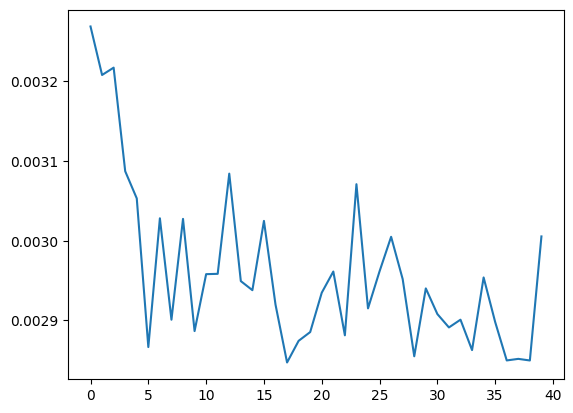

In [96]:
plt.plot(val_losses)

In [87]:
results_df

,종목코드,final_return,순위
0,A282330,[0.013759688],10
1,A126600,[-0.000577122],2
2,A138930,[-0.0035121394],1
3,A001460,[0.008928761],7
4,A013720,[0.018268337],11
5,A001040,[0.0076376647],5
6,A079160,[0.005124956],4
7,A035760,[0.008601759],6
8,A311690,[0.0029703535],3
9,A000120,[0.011639856],8
